# Лабораторная работа №11
## Вариант 7

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as sts

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, SGDRegressor

%matplotlib inline

# Задание 1

In [2]:
df = pd.read_csv('Lab_11/Вариант7.csv', sep=';')
df.head()

,f1,f2,f3,f4,f5,f6,y
0,29.325662,48.569645,51.717486,21.405576,22.094373,81.043148,6993.274043
1,33.761957,28.849154,52.064402,19.588474,58.697152,85.826359,7101.283622
2,17.016108,42.485106,74.373242,20.059711,8.937305,91.389350,8083.008304
3,31.731268,56.872182,46.127164,17.787708,23.337855,77.858432,6361.838626
4,21.446337,18.566850,70.668450,7.810873,42.839600,92.114786,7327.061550


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      900 non-null    float64
 1   f2      900 non-null    float64
 2   f3      900 non-null    float64
 3   f4      900 non-null    float64
 4   f5      900 non-null    float64
 5   f6      900 non-null    float64
 6   y       900 non-null    float64
dtypes: float64(7)
memory usage: 49.3 KB


Text(0.5, 0.98, 'Парные диаграммы рассеяния')

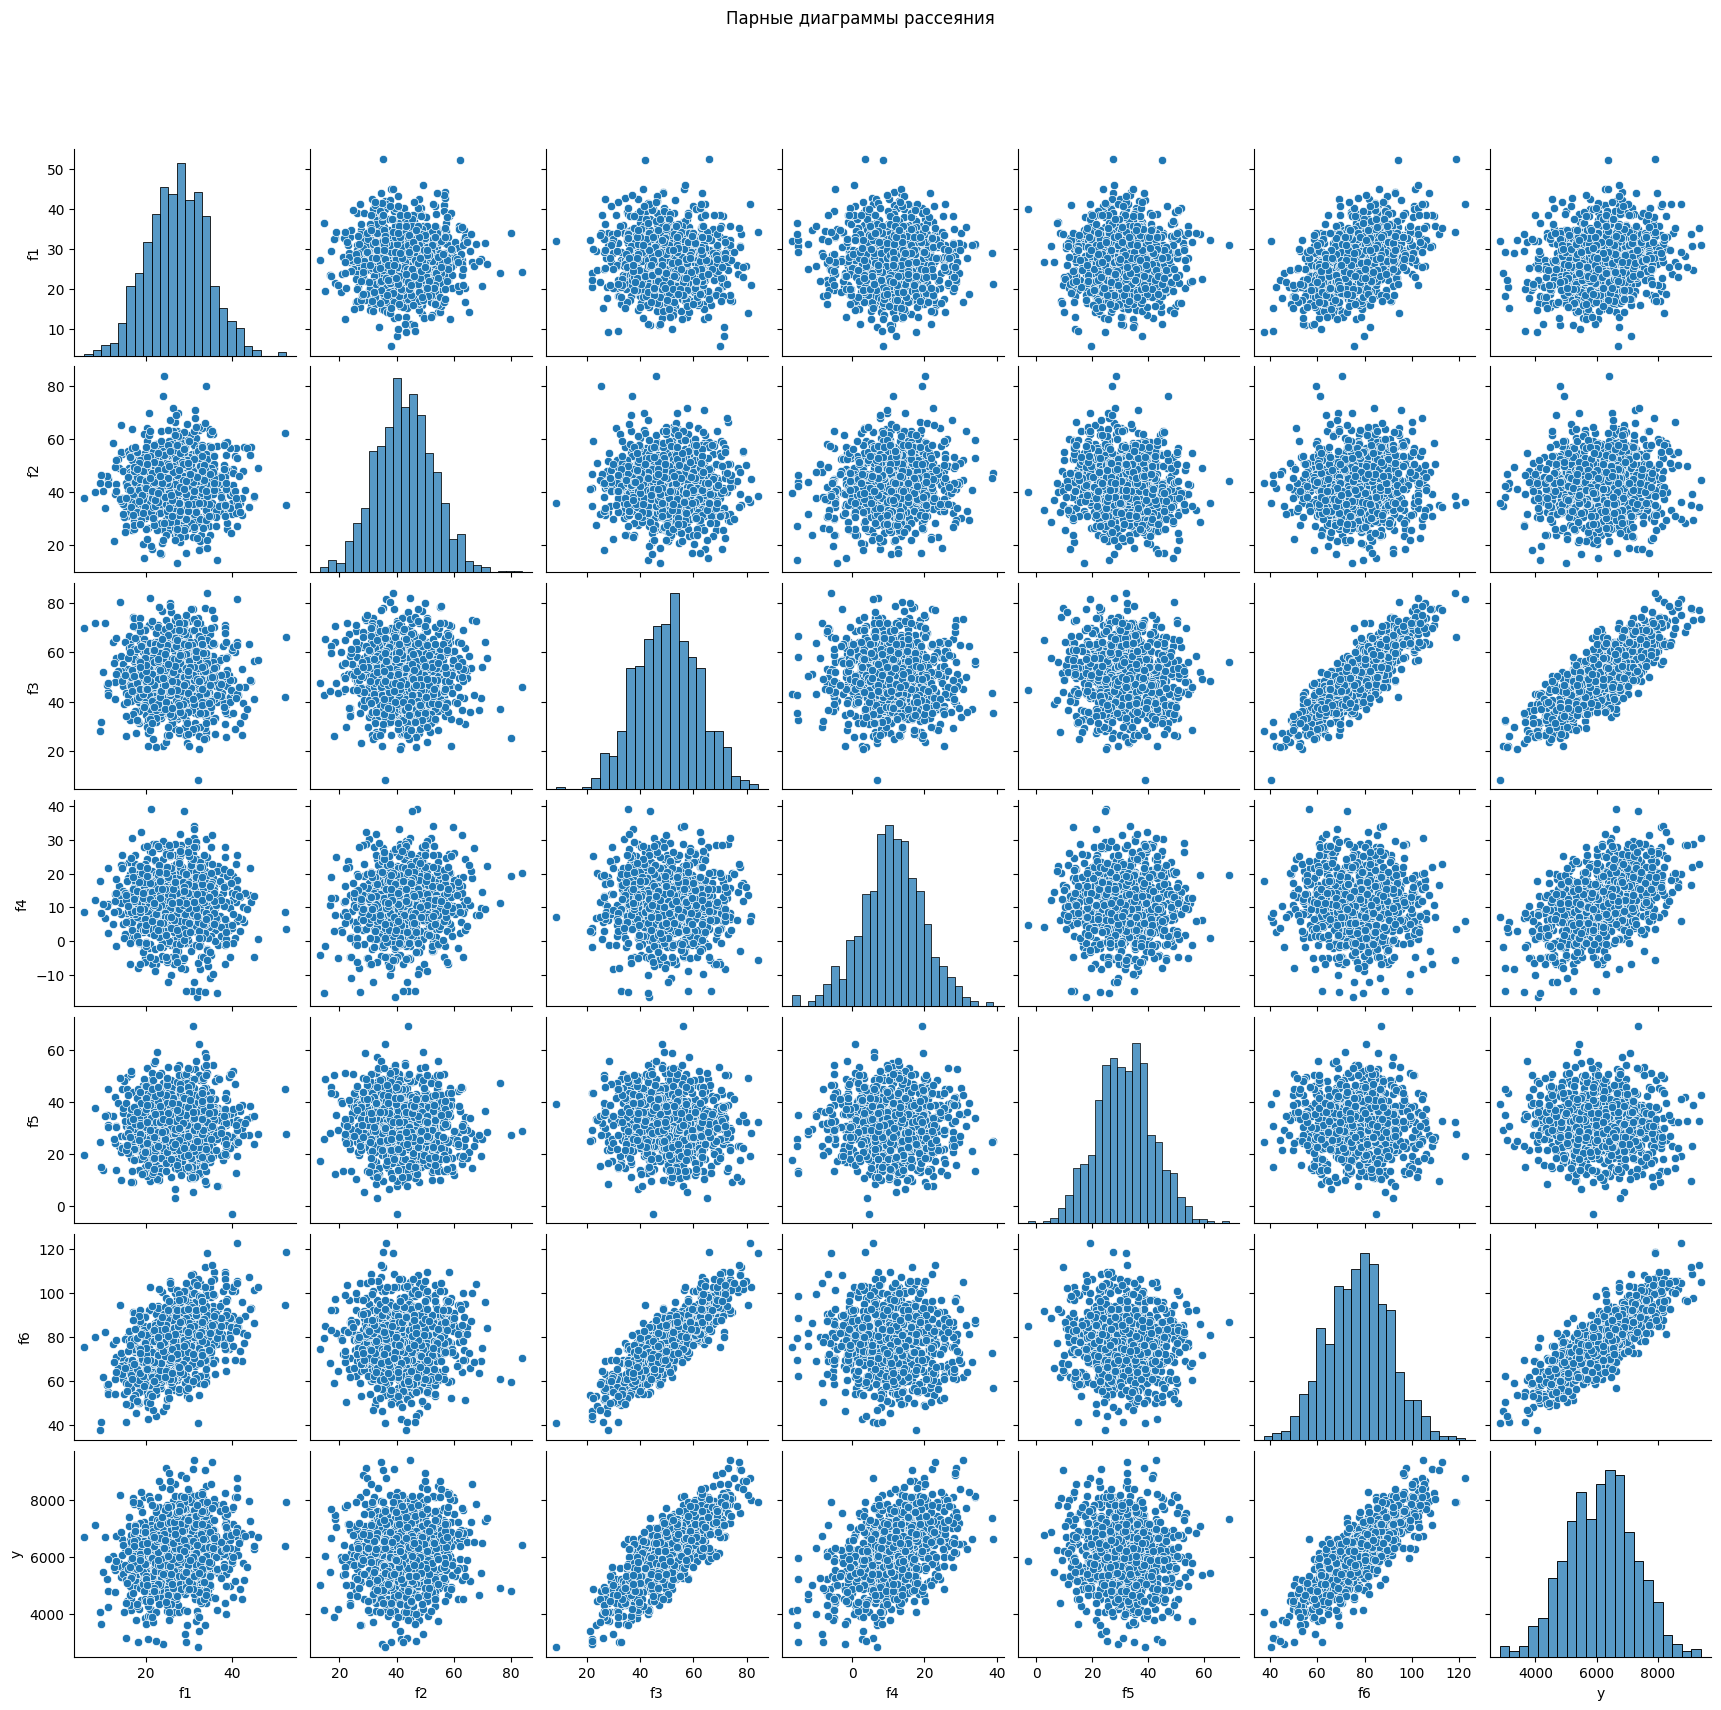

In [4]:
pp = sns.pairplot(df)
pp.fig.subplots_adjust(top=0.9)
pp.fig.suptitle("Парные диаграммы рассеяния")

По визуальной оценке можно выдвинуть предположения:  
1) О нормальном распределении признаков f1, f2, f3, f4, f5, f6;
2) О попарной независимости признаков f1, f2, f3, f4, f5;
3) О парной зависимости признаков f6~f1, f6~f3;
4) О линейной зависимости целевого признака y от признаков f3, f4, f6.

Проверим нормальность распределения признаков.

/tmp/ipykernel_68173/297705227.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column_name], kde=False, fit=sts.lognorm, ax=ax[i], hist_kws={'label':'гистограмма относительных частот'}, fit_kws={'label':'плотность теоретического распределения'})
/home/sai/.local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6547: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


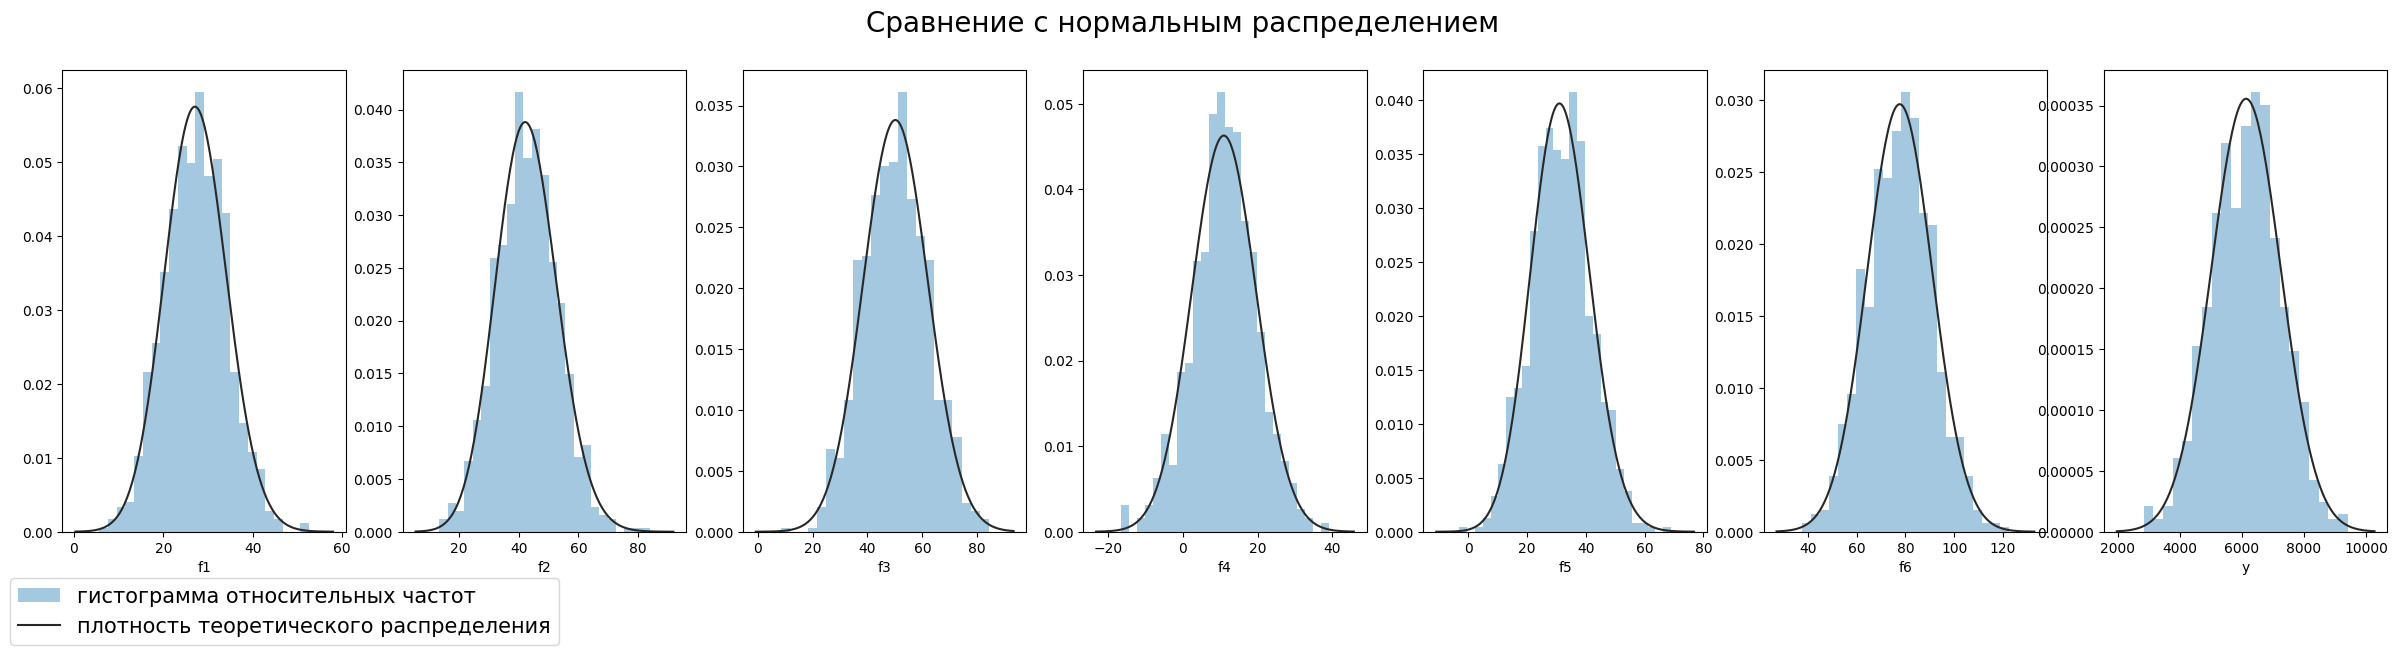

In [5]:
fig, ax = plt.subplots(1, 7)
fig.set_size_inches(30, 6)
fig.suptitle('Сравнение с нормальным распределением ', fontsize=20)
    
for i, column_name in enumerate(df.columns):
    x = np.linspace(min(df[column_name]), max(df[column_name]), 1000)
    sns.distplot(df[column_name], kde=False, fit=sts.lognorm, ax=ax[i], hist_kws={'label':'гистограмма относительных частот'}, fit_kws={'label':'плотность теоретического распределения'})
ax[0].legend(bbox_to_anchor=(1.75 , -0.1 ), borderaxespad= 0, fontsize=15)

По визуальной оценке распределение всех признаков в выборке близко к нормальному. Выбросы можно определить используя диаграмму boxplot.

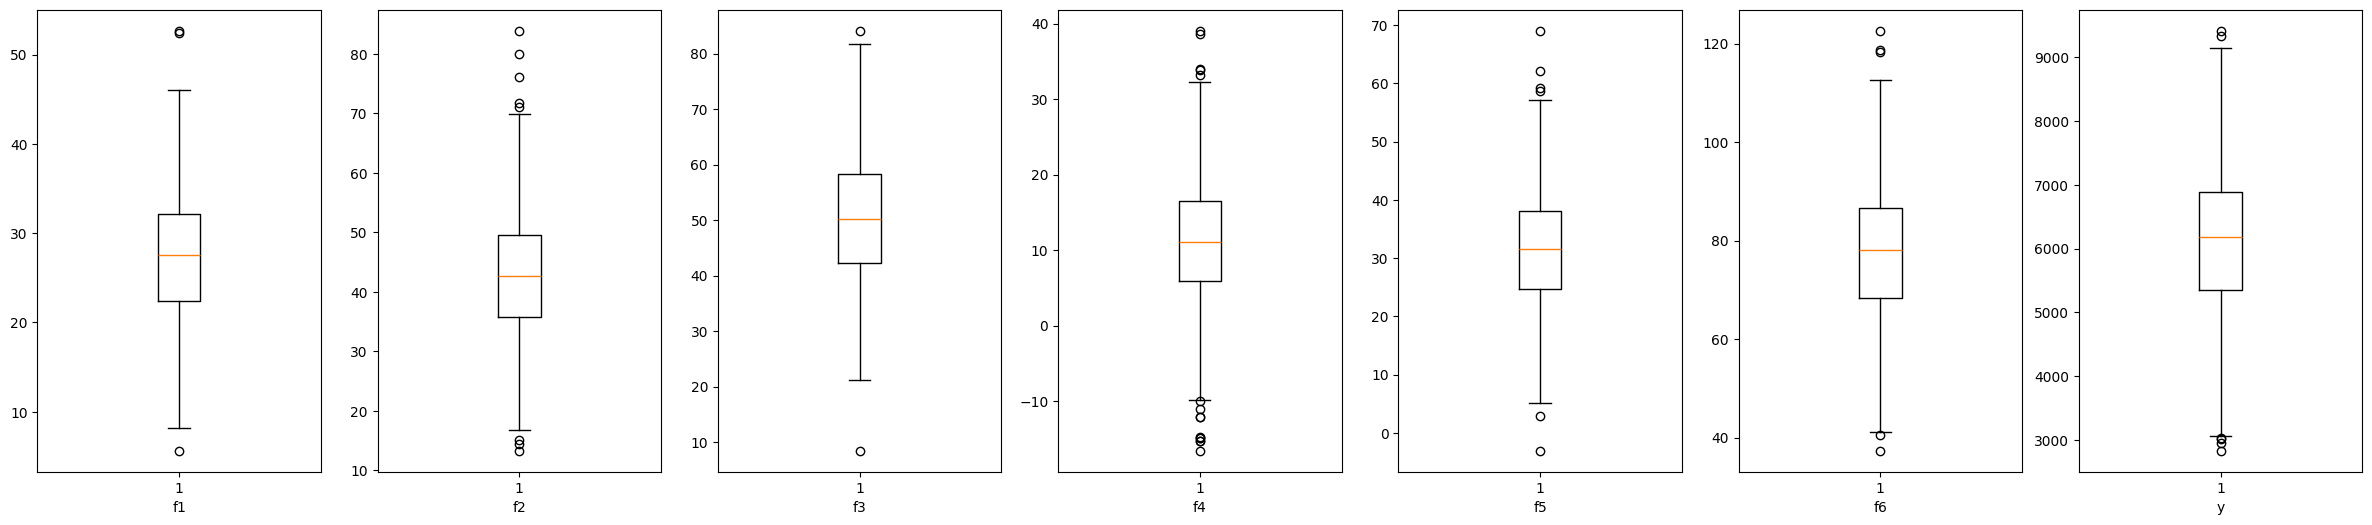

In [6]:
fig, ax = plt.subplots(1, 7)
fig.set_size_inches(30, 6)
for i, column_name in enumerate(df.columns):
    ax[i].boxplot(df[column_name],)
    ax[i].set_xlabel(column_name)


Построим диаграмму папарной корреляции для выявления линейных зависимостей. Т.к. в выборке присутствуют выбросы, будем использовать ранговый коэффициент корреляции Спирмена.

Text(0.5, 1.0, 'Диаграмма выборочной попарной корреляции Спирмена')

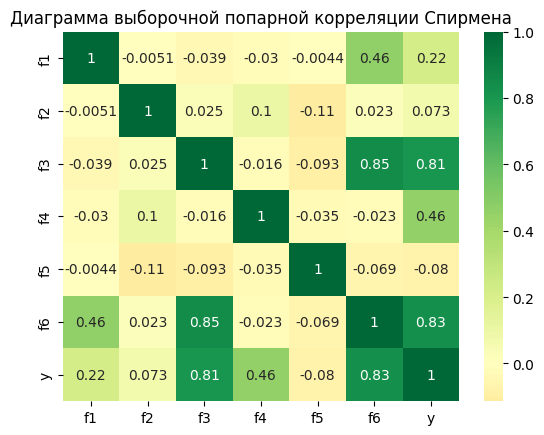

In [7]:
cor = df.corr(method="spearman")
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, cmap='RdYlGn', center=0, annot=True)
plt.title(f"Диаграмма выборочной попарной корреляции Спирмена")


По диаграмме попарной корреляции можно предположить, что признаки f2, f5 являются неинформативными.

In [8]:
def spear(x1, x2):
    
    cor = sts.spearmanr(df[x1], df[x2])
    print(f"Признаки: {x1}, {x2}")
    print(f"Коэффициент корреляции Спирмена: {cor[0]:.02f}")
    print(f"Значение p_value: {cor[1]:.06f}\n")

spear("f1", "f6")
spear("f3", "f6")

Признаки: f1, f6
Коэффициент корреляции Спирмена: 0.46
Значение p_value: 0.000000

Признаки: f3, f6
Коэффициент корреляции Спирмена: 0.85
Значение p_value: 0.000000



Судя по значениям коэффициентов корреляции и p-value можно сказать, что пары признаков f6~f1, f6~f1 являются зависимыми. Наблюдается мультиколлинеарность.  
Перед обучением, для увеличения качества моделей, нужно избавиться от выбросов и мультиколлинеарности.  
Для избавления от мультиколлинеарности можно удалить из выборки признак f6, но, т.к. цель этой лабораторной работы изучить регуляризацию - не будем избавляться от мультиколлинеарности в выборке. Для решения этой проблемы будем использовать регуляризацию. 

Избавимся от выбросов

In [9]:
def filterr(df, colums):
    ix = set(df.index)
    for column_name in colums:
        q1 = np.quantile(df[column_name], 0.25)
        q3 = np.quantile(df[column_name], 0.75)

        q = q1 - 1.5*(q3 - q1), q3 + 1.5*(q3 - q1) 
        ix = ix & set(df[(df[column_name] >= q[0]) & (df[column_name] <= q[1])].index)
        
    return df[df.index.isin(ix)]
f_df = filterr(df, df.columns)

Разобъём выборку на обучающую и тестовую

In [10]:
input_features = ["f1", "f2", "f3", "f4", "f5", "f6"]
x = np.array(f_df[input_features])
y = np.array(f_df["y"]).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=7)
x_train

array([[21.73416266, 31.89128014, 25.09404162,  7.00894533, 34.50021159,
        46.82820428],
       [38.79162705, 41.29881805, 40.92543475,  5.5395305 , 24.52853719,
        79.7170618 ],
       [31.7535012 , 64.58149342, 49.68654799,  4.30106548, 28.99793925,
        81.44004919],
       ...,
       [28.80862618, 62.58172842, 63.66216785,  5.72362962, 45.54928098,
        92.47079403],
       [32.70372315, 46.51672127, 59.34744409, 11.02058723, 29.31309351,
        92.05116723],
       [32.52175807, 37.33772645, 36.21289931,  8.85097086, 48.37786122,
        68.73465738]])

Выполним масштабирование входных признаков

In [11]:
scaler = MinMaxScaler()
scaler.fit(x_train)   
x_train_scaled = scaler.transform(x_train)
x_train_scaled

array([[0.35753686, 0.28440028, 0.06530261, 0.40024729, 0.56540775,
        0.07964114],
       [0.80829123, 0.46161485, 0.32624397, 0.36536804, 0.3738157 ,
        0.54652721],
       [0.62230427, 0.90020243, 0.47064925, 0.33597081, 0.45968913,
        0.57098652],
       ...,
       [0.54448407, 0.86253184, 0.70100277, 0.36973797, 0.77770047,
        0.72757758],
       [0.64741449, 0.55990715, 0.62988522, 0.49547094, 0.46574439,
        0.72162061],
       [0.64260595, 0.38699776, 0.24856948, 0.44397113, 0.83204776,
        0.39062238]])

In [12]:
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
print(f"Полученные коэффициенты: {linear_model.coef_[0]}")

Полученные коэффициенты: [-7.28074320e+13  4.71875000e+00 -1.16728636e+14  2.74394727e+03
  1.92187500e+01  1.35531132e+14]


Можно заметить, что значения коэффициентов для признаков f1, f3, f6 получились порядка 10^14. Огромные значения коэффициентов в уравнении регрессии свидетельствуют о переобучении. Переобучение возникло вследствии мультиколлинеарности.

In [13]:
l_y_train_predict = linear_model.predict(x_train_scaled)
l_y_train_predict[:5]

array([[3592.75      ],
       [5515.7890625 ],
       [5837.4453125 ],
       [4553.73828125],
       [4548.3828125 ]])

In [14]:
print(f"""На тренировочной выборке:
MSE: {mse(l_y_train_predict, y_train)}
MAE: {mae(l_y_train_predict, y_train)}
r2 : {r2(l_y_train_predict, y_train)}
""")


На тренировочной выборке:
MSE: 8145.150925761361
MAE: 79.09707479039213
r2 : 0.9928863596911169



Метрики MSE, MAE получились достаточно небольшие - это хорошо. Метрика r2 -> 1 - это хорошо.

In [15]:
x_test_scaled = scaler.transform(x_test)
x_test_scaled[:5]

array([[0.53377261, 0.65494218, 0.61958717, 0.5206554 , 0.40915751,
        0.65170271],
       [0.44621548, 0.7753765 , 0.75355611, 0.60155741, 0.58092498,
        0.72005012],
       [0.58613877, 0.84058514, 0.71020288, 0.47476019, 0.75264724,
        0.75787828],
       [0.27401548, 0.47669716, 0.77953975, 0.07296047, 0.51567504,
        0.64992303],
       [0.28567322, 0.41653421, 0.49103936, 0.71562534, 0.41661576,
        0.40770941]])

In [16]:
l_y_test_predict = linear_model.predict(x_test_scaled)
l_y_test_predict[:5]

array([[6923.9765625],
       [7660.2109375],
       [7335.2890625],
       [6049.3828125],
       [6419.078125 ]])

In [17]:
print(f"""На тестовой выборке:
MSE: {mse(l_y_test_predict, y_test)}
MAE: {mae(l_y_test_predict, y_test)}
r2 : {r2(l_y_test_predict, y_test)}
""")

На тестовой выборке:
MSE: 8168.139420791561
MAE: 77.81383701014418
r2 : 0.9936129509164966



На тестовой выборке метрики не ухудшились, это говорит о хорошей обобщающей способности модели.

In [18]:
l2 = Ridge(5)
l2.fit(x_train_scaled, y_train)
l2_y_train_predict = l2.predict(x_train_scaled)
l2_y_test_predict = l2.predict(x_test_scaled)

print(f"""На тренировочной выборке:
MSE: {mse(l2_y_train_predict, y_train)}
MAE: {mae(l2_y_train_predict, y_train)}
r2 : {r2(l2_y_train_predict, y_train)}
""")
print(f"""На тестовой выборке:
MSE: {mse(l2_y_test_predict, y_test)}
MAE: {mae(l2_y_test_predict, y_test)}
r2 : {r2(l2_y_test_predict, y_test)}
""")

На тренировочной выборке:
MSE: 22151.582869371683
MAE: 119.29296538364194
r2 : 0.9757895557162948

На тестовой выборке:
MSE: 24119.52594270503
MAE: 126.78513509822632
r2 : 0.9766211186400029



Значения метрик на тестовой выборке хуже, чем на обучающей. Это свидетельствует о невысокой обобщающей способности.  
Значения метрик ухудшились по сравнению с предыдущей моделью без регуляризации.

In [19]:
l1 = Lasso(5)
l1.fit(x_train_scaled, y_train)
l1_y_train_predict = l1.predict(x_train_scaled)
l1_y_test_predict = l1.predict(x_test_scaled)

print(f"""На тренировочной выборке:
MSE: {mse(l1_y_train_predict, y_train)}
MAE: {mae(l1_y_train_predict, y_train)}
r2 : {r2(l1_y_train_predict, y_train)}
""")
print(f"""На тестовой выборке:
MSE: {mse(l1_y_test_predict, y_test)}
MAE: {mae(l1_y_test_predict, y_test)}
r2 : {r2(l1_y_test_predict, y_test)}
""")


На тренировочной выборке:
MSE: 9671.969292754604
MAE: 82.94457683844031
r2 : 0.9909263572766096

На тестовой выборке:
MSE: 10256.850680701073
MAE: 85.38287817836768
r2 : 0.9914119831856312



Значения метрик на тестовой выборке хуже, чем на обучающей. Это свидетельствует о невысокой обобщающей способности.  
Значения метрик ухудшились по сравнению с моделью без регуляризации.

In [20]:
print(linear_model.coef_)

[[-7.28074320e+13  4.71875000e+00 -1.16728636e+14  2.74394727e+03
   1.92187500e+01  1.35531132e+14]]


y = -7.28 * 10^13 * x1  + 4.71 * x2 - 1.16 * 10^14 * x3 + 2.74 * 10^3 * x4 + 19.2 * x5 + 1.35 * 10^14 * x6

Text(0, 0.5, 'Ответы')

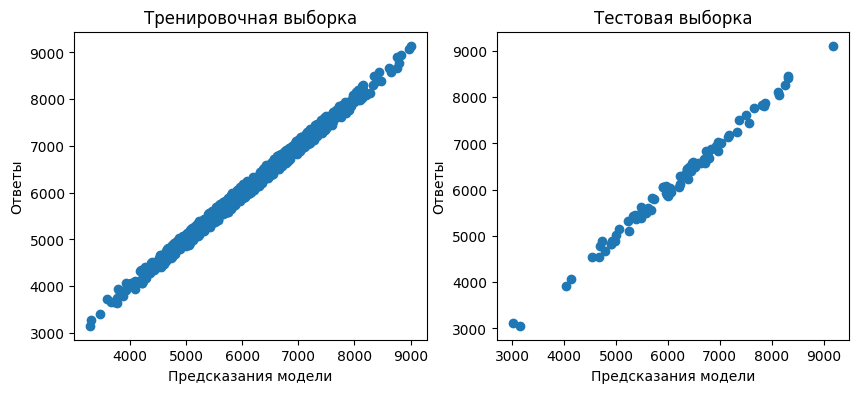

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].scatter(l_y_train_predict, y_train)
ax[0].set_title("Тренировочная выборка")
ax[0].set_xlabel("Предсказания модели")
ax[0].set_ylabel("Ответы")

ax[1].scatter(l_y_test_predict, y_test)
ax[1].set_title("Тестовая выборка")
ax[1].set_xlabel("Предсказания модели")
ax[1].set_ylabel("Ответы")

Судя по графикам модель без регуляризации очень хорошо предсказывает признак y. Модели с регуляризацией показали результаты хуже, несмотря на присутствие мультиколлинеарности в выборке. Возможно, это произошло потому, что простая модель без регуляризации и так хорошо предсказывает целевой признак или коэффициент регуляризации был подобран неправильно.

## Задание 2

In [36]:
print("l  alpha  coef")
for l in ("l1", "l2"):
    for a in (0.01, 0.1, 0.5, 1, 5, 10, 15):
        sgdr = SGDRegressor(penalty=l, alpha=a)
        sgdr.fit(x_train_scaled, np.ravel(y_train))
        print(l, a, [round(i, 2) for i in sgdr.coef_])
        
    print()

l  alpha  coef
l1 0.01 [397.63, 20.24, 2862.85, 2727.67, 23.53, 2348.2]
l1 0.1 [394.3, 16.4, 2860.39, 2724.6, 19.49, 2347.74]
l1 0.5 [386.03, 12.66, 2847.67, 2707.8, 10.48, 2348.07]
l1 1 [365.89, 0.0, 2833.17, 2701.34, 0.0, 2350.46]
l1 5 [232.62, 0.0, 2709.52, 2589.67, 0.0, 2371.77]
l1 10 [112.88, 0.0, 2594.25, 2440.95, 0.0, 2346.93]
l1 15 [102.72, 0.0, 2520.02, 2263.87, 0.0, 2241.89]

l2 0.01 [395.24, 102.8, 2406.98, 2144.61, 5.71, 2105.35]
l2 0.1 [598.06, 477.79, 1258.01, 1038.49, 391.95, 1201.69]
l2 0.5 [216.91, 172.34, 435.57, 332.41, 132.44, 434.01]
l2 1 [57.77, 36.58, 179.53, 115.3, 10.42, 176.96]
l2 5 [10.5, 4.6, 33.19, 19.37, -1.43, 33.67]
l2 10 [7.0, 4.07, 20.13, 13.72, 1.56, 19.93]
l2 15 [2.59, 2.18, 12.62, 7.92, -0.52, 11.53]



Можно заметить, что с увеличением параметра alpha модель l1 успешно определяет незначимые признаки. В модели l2 с увеличением параметра alpha заметно уменьшаются коэффициенты признаков.

In [40]:
print("l  alpha  mse(train) mae(train) r2(train)")
for l in ("l1", "l2"):
    for a in (0.01, 0.1, 0.5, 1, 5, 10, 15):
        sgdr = SGDRegressor(penalty=l, alpha=a)
        sgdr.fit(x_train_scaled, np.ravel(y_train))

        y_train_predict = sgdr.predict(x_train_scaled)
        print(l, a, round(mse(y_train, y_train_predict), 2), round(mae(y_train, y_train_predict), 2), round(r2(y_train, y_train_predict), 2))
        
    print()


l  alpha  mse(train) mae(train) r2(train)
l1 0.01 8173.75 79.06 0.99
l1 0.1 8159.33 79.03 0.99
l1 0.5 8204.94 79.08 0.99
l1 1 8293.26 79.24 0.99
l1 5 10314.69 84.84 0.99
l1 10 16339.39 103.25 0.99
l1 15 25646.98 128.75 0.98

l2 0.01 36278.56 152.28 0.97
l2 0.1 363577.21 488.75 0.68
l2 0.5 817164.4 736.64 0.29
l2 1 1015298.64 822.31 0.12
l2 5 1125497.83 865.55 0.02
l2 10 1142105.92 872.01 0.01
l2 15 1143772.9 872.59 0.01



С увеличением alpha метрики ухудшаются.

In [41]:
print("l  alpha  mse(test) mae(test) r2(test)")
for l in ("l1", "l2"):
    for a in (0.01, 0.1, 0.5, 1, 5, 10, 15):
        sgdr = SGDRegressor(penalty=l, alpha=a)
        sgdr.fit(x_train_scaled, np.ravel(y_train))

        y_test_predict = sgdr.predict(x_test_scaled)
        print(l, a, round(mse(y_test, y_test_predict), 2), round(mae(y_test, y_test_predict), 2), round(r2(y_test, y_test_predict), 2))
        
    print()

l  alpha  mse(test) mae(test) r2(test)
l1 0.01 8247.04 77.94 0.99
l1 0.1 8240.11 78.01 0.99
l1 0.5 8333.87 78.59 0.99
l1 1 8431.47 79.28 0.99
l1 5 11249.54 88.89 0.99
l1 10 18381.04 111.71 0.99
l1 15 27852.68 136.35 0.98

l2 0.01 40073.33 161.96 0.97
l2 0.1 407835.93 497.1 0.69
l2 0.5 945691.56 761.98 0.27
l2 1 1139874.77 831.12 0.13
l2 5 1280763.44 879.99 0.02
l2 10 1299177.47 886.2 0.0
l2 15 1297685.65 885.54 0.0



С увеличением alpha метрики ухудшаются. Метрики на тестовой выборке хуже, что говорит о плохой обобщающей способности моделей. Регуляризатор l1 показывает лучшие результаты, чем l2. 

среди рассмотренных моделей лучшую метрику MSE показали модели l1 alpha=0.1; l2 alpha=0.01. более детально рассмотрим окрестности этих точек.

In [45]:
l = "l1"
l1 = []
for a in np.linspace(0.05, 0.15, 100):
    sgdr = SGDRegressor(penalty=l, alpha=a)
    sgdr.fit(x_train_scaled, np.ravel(y_train))

    y_test_predict = sgdr.predict(x_test_scaled)
    l1.append((mse(y_test, y_test_predict), a))
l1.sort()
print(f"Среди моделей {l} лучше по метрике mse показала себя модель с параметром alpha={l1[0][1]:.02f}")
print(f"mse = {l1[0][0]:.02f}")

Среди моделей l1 лучше по метрике mse показала себя модель с параметром alpha=0.12
mse = 8214.16


In [49]:
l = "l2"
l2 = []
for a in np.linspace(0, 0.02, 100):
    sgdr = SGDRegressor(penalty=l, alpha=a)
    sgdr.fit(x_train_scaled, np.ravel(y_train))

    y_test_predict = sgdr.predict(x_test_scaled)
    l2.append((mse(y_test, y_test_predict), a))
l2.sort()
print(f"Среди моделей {l} лучше по метрике mse показала себя модель с параметром alpha={l2[0][1]:.03f}")
print(f"mse = {l2[0][0]:.02f}")

Среди моделей l2 лучше по метрике mse показала себя модель с параметром alpha=0.000
mse = 8239.08


Как мы видим, среди моделей l2 лучшим вариантом будет использовать модель с парметром alpha=0. То есть лучше отказаться от использования модели l2 в пользу модели без регуляризации.

Среди моделей l1 найдена оптимальная модель с параметром alpha=0.12

Вывод: регуляризация может как улучшить метрики для линейных регрессионных моделей, так и ухудшить. Для поиска оптимальных гиперпараметров следует рассмотреть множество вариантов и выбрать среди них тот, который показывает лучшую метрику.